In [51]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Adaline (Adaptive Linear Element) and Linear Regression

Useful links:

* https://en.wikipedia.org/wiki/ADALINE
* https://com-cog-book.github.io/com-cog-book/features/adaline.html


### Setup


In [52]:
# If True, test is running on Colab. Otherwise, test if assumed to be offline.
TEST_ON_COLAB = False

FOLDERNAME = "Colab Notebooks/ann/3_activation-functions" # only used if TEST_ON_COLAB is True
DATASET_OPENML_ID = "spambase" # dataset to use for testing  

assert not (FOLDERNAME is None and TEST_ON_COLAB), "FOLDERNAME has to be set if TEST_ON_COLAB is True"
assert DATASET_OPENML_ID is not None, "DATASET_OPENML_ID is not set"

Set a seed for reproducibility:

In [53]:
SEED = 42

In [54]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(SEED)

## Adaline and Linear Regression

For $\phi$ as the identity function, the output of the perceptron is

$$
\begin{aligned}
\hat{y} & = \phi(\mathbf{w} \cdot \mathbf{x})\\
        & = \mathbf{w} \cdot \mathbf{x},
\end{aligned}
$$


With the loss function $L = (y - \hat{y})^2$, the gradient of the loss function with respect to the weights is:

$$
\begin{aligned}
\frac{\partial L}{\partial \mathbf{w}} & = \frac{\partial}{\partial \mathbf{w}} (y - \hat{y})^2\\
                                       & = \frac{\partial}{\partial \mathbf{\hat{y}}} (y - \hat{y})^2 \frac{\partial \hat{y}}{\partial \mathbf{w}}\\
                                        & = -2(y - \hat{y}) \frac{\partial \hat{y}}{\partial \mathbf{w}}\\
                                        & = -2(y - \hat{y}) \frac{\partial}{\partial \mathbf{w}} (\mathbf{w} \cdot \mathbf{x})\\
                                        & = -2(y - \hat{y}) \mathbf{x}.
\end{aligned}
$$

This can be used for Adaline (Widrow-Hoff learning rule with binary outputs) and linear regression.

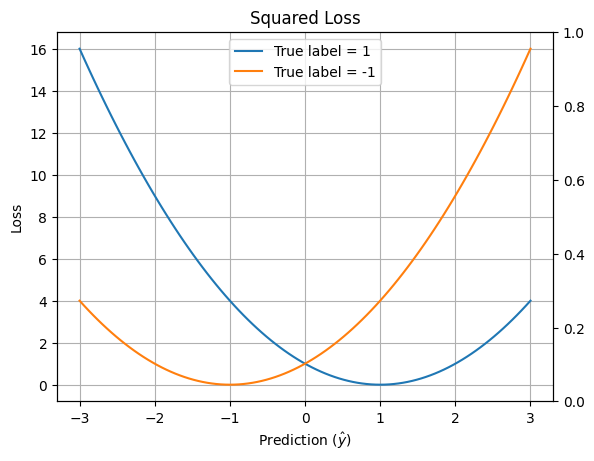

In [55]:
y_pred = np.linspace(-3, 3, 100)
loss_p1 = (1 - y_pred)**2 # loss for true label = 1 (positive)
loss_m1 = (-1 - y_pred)**2 # loss for true label = -1 (negative)

fig, ax = plt.subplots()
ax.plot(y_pred, loss_p1, label="True label = 1")
ax.plot(y_pred, loss_m1, label="True label = -1")
ax.set_xlabel("Prediction $(\hat{y})$")
ax.set_ylabel("Loss")
ax.set_title("Squared Loss")
ax.legend()
ax.grid()

ax2 = ax.twinx()

### Adaline

The Adaline algorithm is:

1. Initialize the weights $\mathbf{w}$.
2. For each training example $\mathbf{x}$:
    1. Compute the output $\hat{y} = \mathbf{w} \cdot \mathbf{x}$.
    2. Update the weights $\mathbf{w} = \mathbf{w} + \alpha(y - \hat{y})\mathbf{x}$.

Train set size: 80
Test set size: 20


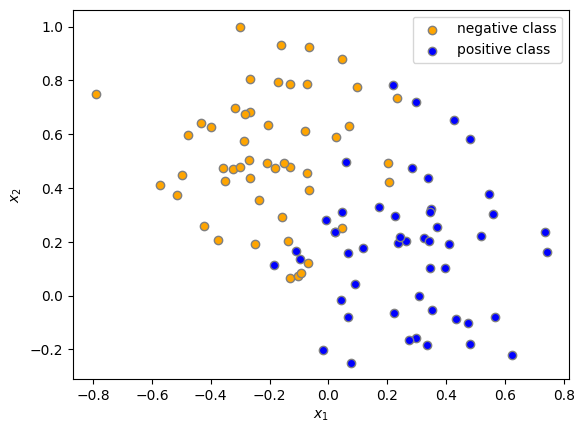

In [56]:
from utils import make_classification_dataset, plot_classification_dataset_2D
from sklearn.model_selection import train_test_split

X, y = make_classification_dataset(100, 2, 2, cluster_std=4)

# Change labels to -1 and 1
y[y==0] = -1

# Normalize X
X = X/X.max()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(f"Train set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

plot_classification_dataset_2D(X, y, negative_label=-1)

w.shape: (3,)


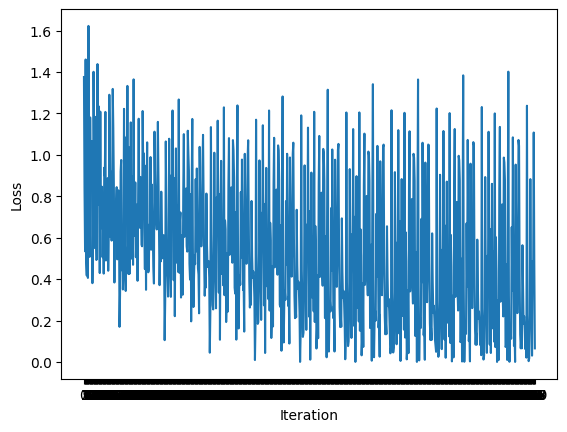

In [57]:
from utils import plot_loss_history

num_epochs = 10
learning_rate = 1e-02

# Add a bias term
X_b = np.hstack([X_train, np.ones((X_train.shape[0], 1))])

# Random weights initialization
w = np.random.normal(size=X_b.shape[1])
print(f"w.shape: {w.shape}")

iteration = 0
loss_history = []
for epoch in range(num_epochs):
    for i in range(len(X_b)):
        y_pred = np.dot(X_b[i], w)

        # Loss
        loss_value = (y_train[i] - y_pred) ** 2
        loss_history.append(loss_value)

        # Update weights
        w = w + learning_rate * (y_train[i] - y_pred) * X_b[i]

        iteration += 1
plot_loss_history(loss_history)

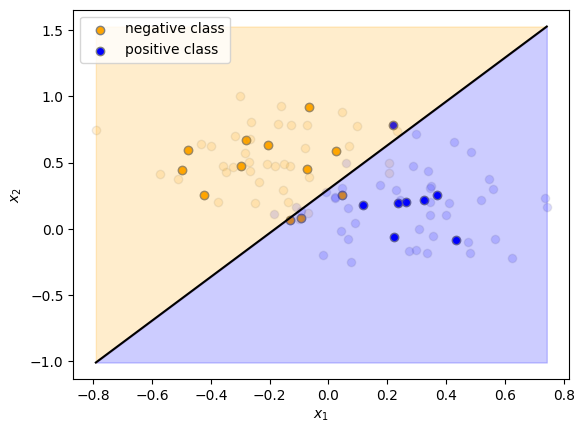

In [58]:
from utils import plot_decision_boundary_2D

fix, ax = plt.subplots()

plot_classification_dataset_2D(X_test, y_test, negative_label=-1, ax=ax)
plot_classification_dataset_2D(X, y, negative_label=-1, alpha=0.15, ax=ax)
plot_decision_boundary_2D(X, w, ax=ax)

plt.show()

Classification report:

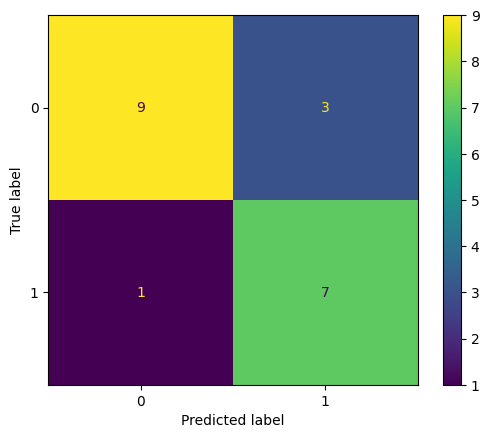


Classification Report:
              precision    recall  f1-score   support

          -1       0.90      0.75      0.82        12
           1       0.70      0.88      0.78         8

    accuracy                           0.80        20
   macro avg       0.80      0.81      0.80        20
weighted avg       0.82      0.80      0.80        20



In [59]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# X_test with bias term
X_b = np.hstack([X_test, np.ones((X_test.shape[0], 1))])

# vectorized prediction
y_pred = np.dot(X_b, w) # dot product with the last axis of w: n x d * d x 1 = n x 1
y_pred = np.where(y_pred > 0, 1, -1)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[-1, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Compute classification reportX[:, 1].min()
class_report = classification_report(y_test, y_pred)

print("\nClassification Report:")
print(class_report)

### A batch gradient descent approach

The previous approach is known as *stochastic gradient descent approach* (SGD) because the weights are updated for each training example. In *batch gradient descent*, the weights are updated after all training examples have been used. This approach is more computationally expensive but can be more stable and accurate than SGD. A batch gradient descent approach can be used as follows:

Now, the loss function is the mean squared error:

$$
L = \frac{1}{N} \sum_i (y_i - \hat{y}_i)^2,
$$

where $N$ is the number of training examples. The gradient of the loss function with respect to the weights is:

$$
\begin{aligned}
\frac{\partial L}{\partial \mathbf{w}} & = \frac{\partial}{\partial \mathbf{w}} \left(\frac{1}{N} \sum_i (y_i - \hat{y}_i)^2\right)\\
                                        & = \frac{1}{N} \sum_i \frac{\partial}{\partial \mathbf{w}} (y_i - \hat{y}_i)^2\\
                                        & = \frac{1}{N} \sum_i -2(y_i - \hat{y}_i) \mathbf{x}_i\\
                                        & = -\frac{2}{N} \sum_i (y_i - \hat{y}_i) \mathbf{x}_i.
\end{aligned}
$$

The Adaline algorithm with batch gradient descent is:

1. Initialize the weights $\mathbf{w}$.
2. For each epoch:
    1. Compute the output $\hat{y}_i = \mathbf{w} \cdot \mathbf{x}_i$ for all training examples.
    2. Update the weights $\mathbf{w} = \mathbf{w} + \alpha \sum_i (y_i - \hat{y}_i)\mathbf{x}_i$.

w.shape: (3,)


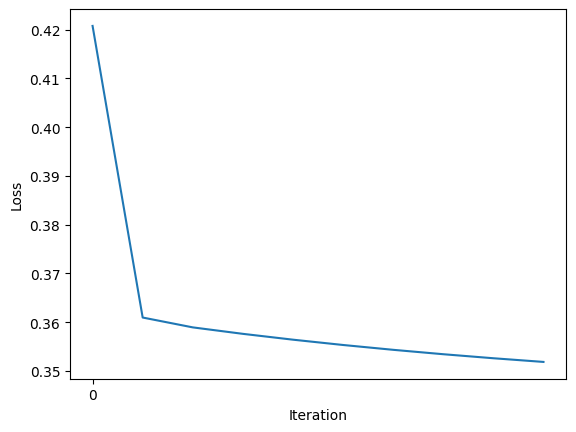

In [60]:
num_epochs = 10
learning_rate = 1e-02

# Add a bias term
X_b = np.hstack([X_train, np.ones((X_train.shape[0], 1))])

# Reinitalize weights
w = np.random.normal(size=X_b.shape[1])
print(f"w.shape: {w.shape}")

iteration = 0
loss_history = []
for epoch in range(num_epochs):
    y_pred = np.dot(X_b, w)
    error = y_train - y_pred
    loss_value = np.mean(error ** 2)
    loss_history.append(loss_value)

    # Update weights
    w = w + learning_rate * np.dot(error, X_b)

    iteration += 1
plot_loss_history(loss_history, interval=20)

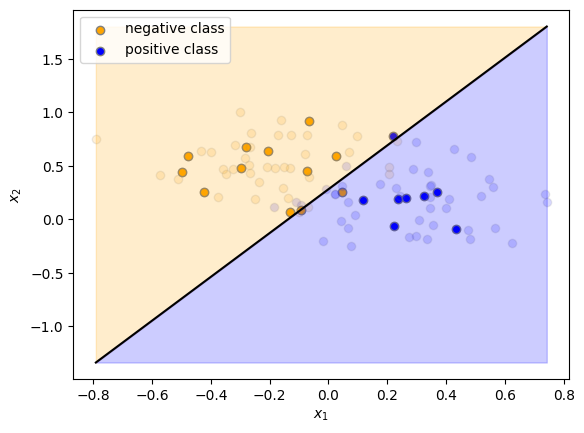

In [61]:
fix, ax = plt.subplots()

plot_classification_dataset_2D(X_test, y_test, negative_label=-1, ax=ax)
plot_classification_dataset_2D(X, y, negative_label=-1, alpha=0.15, ax=ax)
plot_decision_boundary_2D(X, w, ax=ax)

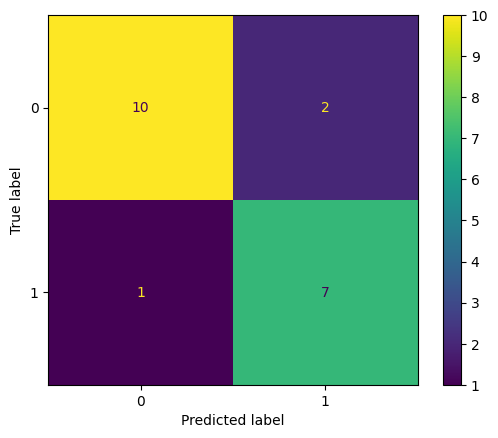


Classification Report:
              precision    recall  f1-score   support

          -1       0.91      0.83      0.87        12
           1       0.78      0.88      0.82         8

    accuracy                           0.85        20
   macro avg       0.84      0.85      0.85        20
weighted avg       0.86      0.85      0.85        20



In [62]:
# X_test with bias term
X_b = np.hstack([X_test, np.ones((X_test.shape[0], 1))])

# vectorized prediction
y_pred = np.dot(X_b, w)  # dot product with the last axis of w: n x d * d x 1 = n x 1
y_pred = np.where(y_pred > 0, 1, -1)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[-1, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Compute classification reportX[:, 1].min()
class_report = classification_report(y_test, y_pred)

print("\nClassification Report:")
print(class_report)

### Linear Regression

Unlike the classification model, the output of the linear regression model is not binary. The output is the same as the input, i.e., $\hat{y} = \mathbf{w} \cdot \mathbf{x}$. For a 1D input $x$, $\mathbf{x} = (x, 1)$ and $\mathbf{w} = (w, b)$, where $w$ is the slope and $b$ is the bias. Therefore,

$$
\begin{aligned}
\hat{y} & = \mathbf{w} \cdot \mathbf{x}\\
        & = (w, b) \cdot (x, 1)\\
        & = w x + b.
\end{aligned}
$$        

The loss function, update rule, and algorithm are the same as Adaline. 

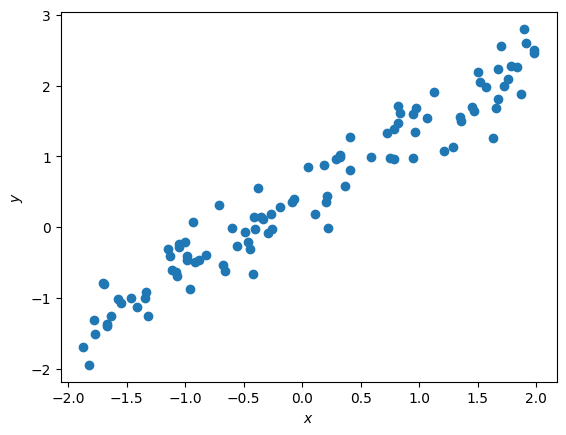

In [63]:
from utils import make_linear_regression_dataset, plot_regression_dataset_1D

x, y = make_linear_regression_dataset(n_samples=100, x_min=-2, x_max=2, w=1.0, noise=0.3)
plot_regression_dataset_1D(x, y)

In [64]:
# Add a new dimension to x
X = x[:, np.newaxis]
print(X[:5])

# Add a bias term
X_b = np.hstack([X, np.ones((X.shape[0], 1))])
print(X_b[:5])

[[-1.63318341]
 [ 0.4097637 ]
 [ 0.21481221]
 [-1.14908842]
 [ 1.78477817]]
[[-1.63318341  1.        ]
 [ 0.4097637   1.        ]
 [ 0.21481221  1.        ]
 [-1.14908842  1.        ]
 [ 1.78477817  1.        ]]


w.shape: (2,)


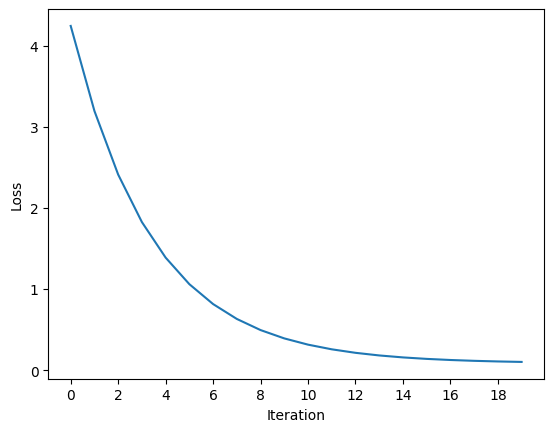

In [65]:
num_epochs = 20
learning_rate = 1e-03

# Reinitalize weights
w = np.random.normal(size=X_b.shape[1])
print(f"w.shape: {w.shape}")

iteration = 0
loss_history = []
for epoch in range(num_epochs):
    y_pred = np.dot(X_b, w)
    error = y - y_pred
    loss_value = np.mean(error**2)
    loss_history.append(loss_value)

    # Update weights
    w = w + learning_rate * np.dot(error, X_b)

    iteration += 1
plot_loss_history(loss_history, interval=2)

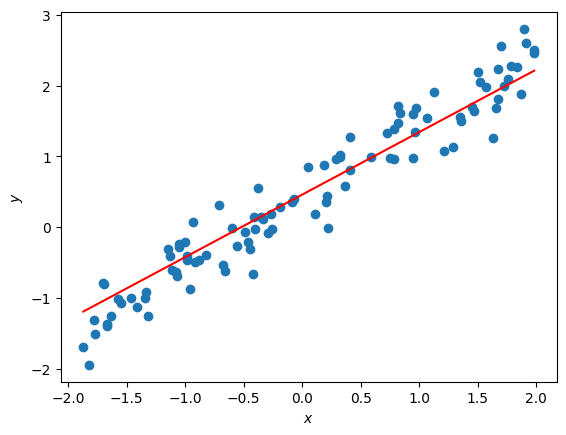

In [66]:
plot_regression_dataset_1D(x, y)

x1 = X_b[:, 0].min()
x2 = X_b[:, 0].max()
y1 = w[0] * x1 + w[1] # wx + b
y2 = w[0] * x2 + w[1]
plt.plot([x1, x2], [y1, y2], color="red")
plt.show()